In [1]:
import gzip
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
def parse(f):
    for l in gzip.open(f):
        yield eval(l)
dataset = list(parse('train.json.gz'))

In [3]:
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u,g,d

In [4]:
#shuffling data
random.shuffle(dataset)
len(dataset)

175000

In [5]:
train_set, validation_set = train_test_split(dataset, test_size=0.05714, random_state=42)

In [6]:
id_game_trainSet = [(train_set[d]['userID'], train_set[d]['gameID'], 1) for d in range(len(train_set))]
id_game_valSet_played = [(validation_set[d]['userID'], validation_set[d]['gameID'], 1) for d in range(len(validation_set))]

1. Although we have built a validation set, it only consists of positive samples. For this task we also need examples of user/item pairs that weren’t played. For each entry (user,game) in the validation set, sample a negative entry by randomly choosing a game that user hasn't played. Evaluate the perfomance (accuracy) of the baseline model on the validation set you have built/

In [7]:
#all game with no dulicated
val_gameid = [ d['gameID'] for d in dataset]
game = []
for d in val_gameid:
    if d not in game:
        game.append(d) 

In [8]:
id_game_valSet_not_played = []
for i in id_game_valSet_played:
    while True:
        random_game = random.choice(game)
        while True:
            if (i[0], random_game) in id_game_valSet_played or (i[0], random_game) in id_game_valSet_not_played:
                random_game = random.choice(game)
            else:
                break
                
        if i[1] != random_game:
            id_game_valSet_not_played.append((i[0], random_game, 0))
            break
            
id_game_valSet = id_game_valSet_played + id_game_valSet_not_played

In [9]:
#create a new file for is_game_valSet
test = open("test.txt", 'w')
test.write("userID-gameID,prediction\n")
for d in id_game_valSet:
    test.write(d[0] + '-' + d[1] + '\n')

In [10]:
### Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked

gameCount = defaultdict(int)
totalPlayed = 0

for user,game,_ in id_game_valSet:
    gameCount[game] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/2: break

predictions = open("predictions_Played.txt", 'w')
predictions_lst = []
for l in open("test.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')

    if g in return1:
        predictions.write(u + '-' + g + ",1\n")
        predictions_lst.append(1)
    else:
        predictions.write(u + '-' + g + ",0\n")
        predictions_lst.append(0)

predictions.close()

In [11]:
#accuracy
count = 0
for i in range(len(predictions_lst)):
    if predictions_lst[i] == id_game_valSet[i][2]:
        count += 1
accuracy = count/len(predictions_lst)
accuracy

0.6609583820316073

2. The existing ‘played prediction’ baseline just returns True if the item in question is ‘popular,’ using a threshold of the 50th percentile of popularity (totalPlayed/2). Assuming that the ‘non-played’ test examples are a random sample of user-game pairs, this threshold may not be the best one. See if you can find a better threshold and report its performance on your validation set (1 mark).

In [12]:
#change the threshold to totalPlayed/1.5
### Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked

gameCount = defaultdict(int)
totalPlayed = 0

for user,game,played in id_game_valSet:
    if played == 1:
        gameCount[game] += 1
        totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/1.5: break

predictions = open("predictions_Played.txt", 'w')
predictions_lst = []
for l in open("test.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')

    if g in return1:
        predictions.write(u + '-' + g + ",1\n")
        predictions_lst.append(1)
    else:
        predictions.write(u + '-' + g + ",0\n")
        predictions_lst.append(0)

predictions.close()

In [13]:
#accuracy
count = 0
for i in range(len(predictions_lst)):
    if predictions_lst[i] == id_game_valSet[i][2]:
        count += 1
accuracy = count/len(predictions_lst)
accuracy

0.7146704608974033

3. A stronger baseline than the one provided might make use of the Jaccard similarity (or another similarity metric). Given a pair (u, g) in the validation set, consider all training items g′ that user u has played. For each, compute the Jaccard similarity between g and g′, i.e., users (in the training set) who have played g and users who have played g' . Predict as ‘played’ if the maximum of these Jaccard similarities exceeds a threshold (you may choose the threshold that works best). Report the performance on your validation set (1 mark).

In [14]:
usersPerGame = defaultdict(set)
gamesPerUser = defaultdict(set)
for d in id_game_trainSet:
    user,game = d[0], d[1]
    usersPerGame[game].add(user)
    gamesPerUser[user].add(game)

In [15]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

def mostSimilarFast(i, j ):
    similarities = []
    games = gamesPerUser[i] #the games that the user i played in the train set
    users = usersPerGame[j] #the game j that users played in train set
    for g in games:
        similarities.append(Jaccard(users, usersPerGame[g]))
    return similarities
threshold = [0.023, 0.033, 0.43, 0.53]
for t in threshold:
    predict_output = []
    for user,game,played in id_game_valSet:
        sim = mostSimilarFast(user, game)
        
        if len(sim) == 0:
            predict_output.append(0)
            break
        if max(sim) > t:
            predict_output.append(1)
        else:
            predict_output.append(0)
    count = 0
    for i in range(len(predict_output)):
        if predict_output[i] == id_game_valSet[i][2]:
            count += 1
    accuracy = count / len(id_game_valSet)
    print('threshold:', t, ',accuracy:', accuracy)
    
predictions = open("predictions_Played.txt", 'w')
predictions_lst = []
for l in open("pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')

    if g in return1:
        predictions.write(u + '-' + g + ",1\n")
        predictions_lst.append(1)
    else:
        predictions.write(u + '-' + g + ",0\n")
        predictions_lst.append(0)

predictions.close()

threshold: 0.023 ,accuracy: 0.63625
threshold: 0.033 ,accuracy: 0.66845
threshold: 0.43 ,accuracy: 0.4925
threshold: 0.53 ,accuracy: 0.4925


4. Improve the above predictor by incorporating both a Jaccard-based threshold and a popularity based threshold. Report the performance on your validation set.

In [16]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

def mostSimilarFast(i, j ):
    similarities = []
    games = gamesPerUser[i] #the games that the user i played in the train set
    users = usersPerGame[j] #the game j that users played in train set
    for g in games:
        similarities.append(Jaccard(users, usersPerGame[g]))
    return similarities


gameCount = defaultdict(int)
totalPlayed = 0

for user,game,played in id_game_valSet:
    if played == 1:
        gameCount[game] += 1
        totalPlayed += 1
    sim = mostSimilarFast(user, game)

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

popularity = set()
count = 0
for ic, i in mostPopular:
    count += ic
    popularity.add(i)
    if count > totalPlayed/1.5: break
        
        

predict_output = []
for user,game,played in id_game_valSet:
    sim = mostSimilarFast(user, game)
        
    if len(sim) == 0:
        predict_output.append((user,game,0))
        break
    if max(sim) > 0.033 and game in popularity:
        predict_output.append((user,game,1))
    else:
        predict_output.append((user,game,0))

count = 0
for i in range(len(predict_output)):
    if predict_output[i][2] == id_game_valSet[i][2]:
        count += 1
accuracy = count / len(id_game_valSet)
print('threshold:', 0.033, ',accuracy:', accuracy)

threshold: 0.033 ,accuracy: 0.68395


5. To run our model on the test set, we’ll have to use the files ‘pairs Played.txt’ to find the reviewerID/itemID pairs about which we have to make predictions. Using that data, run the above model and upload your solution to Kaggle. Tell us your Kaggle user name (1 mark). If you’ve already uploaded a better solution to Kaggle, that’s fine too!


In [17]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

def mostSimilarFast(i, j ):
    similarities = []
    games = gamesPerUser[i] #the games that the user i played in the train set
    users = usersPerGame[j] #the game j that users played in train set
    for g in games:
        similarities.append(Jaccard(users, usersPerGame[g]))
    return similarities


gameCount = defaultdict(int)
totalPlayed = 0

for user,game,played in id_game_valSet:
    if played == 1:
        gameCount[game] += 1
        totalPlayed += 1
    sim = mostSimilarFast(user, game)

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

popularity = set()
count = 0
for ic, i in mostPopular:
    count += ic
    popularity.add(i)
    if count > totalPlayed/1.5: break
        
        
predictions = open("predictions_Played.txt", 'w')
for l in open("pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    
    sim = mostSimilarFast(u, g)
        
    if len(sim) == 0:
        predictions.write(u + '-' + g + ",0\n")
    elif max(sim) > 0.033 and g in popularity:
        predictions.write(u + '-' + g + ",1\n")
    else:
        predictions.write(u + '-' + g + ",0\n")
        
predictions.close()

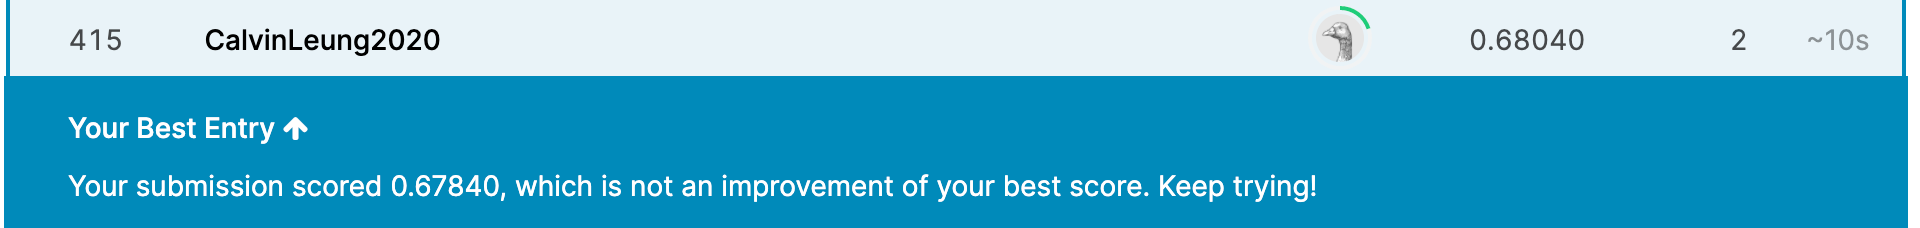